In [1]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F

In [2]:
# set up the path
data_path = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot.metadata.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics/data/external/scenicornot') 

# Check if the data path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at {data_path}")

# Read the data
data = pd.read_csv(data_path)

# Check if the root directory exists
root_dir = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/'
if not os.path.exists(root_dir):
    raise FileNotFoundError(f"Root directory not found at {root_dir}")

# prepocess the dataset, remove the invalid paths
valid_files = []
missing_files = []
for idx in range(len(data)):
    img_name = data.iloc[idx]['filename']
    image_path = image_folder / Path(img_name)
    if image_path.exists():
        valid_files.append(idx)
    else:
        missing_files.append(image_path)

if missing_files:
    print(f"Missing {len(missing_files)} files:")
    for file in missing_files:
        print(file)

# only keep the valid file record
valid_data = data.iloc[valid_files].reset_index(drop=True)

Missing 1 files:
/home/ubuntu/landscape-aesthetics/data/external/scenicornot/photos/76/41/764143_e860c8c4.jpg


In [3]:
# add a weights return of the dataset class
class ScenicDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        # calculate the weight of each score
        self.class_weights = 1. / data_frame['average'].value_counts()
        self.data_frame['weight'] = self.data_frame['average'].map(self.class_weights)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx]['filename']) # combine root address with filename
        try:
            image = Image.open(img_name).convert('RGB')
        except (IOError, SyntaxError) as e:
          # return None, None, None
            return self.__getitem__((idx + 1) % len(self)) # return the next sample
        rating = self.data_frame.iloc[idx]['average']
        weight = self.data_frame.iloc[idx]['weight']
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(rating, dtype=torch.float32), torch.tensor(weight, dtype=torch.float32)

# centered crop
data_transforms = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

image_dataset = ScenicDataset(data_frame=data,
                              root_dir='/home/ubuntu/landscape-aesthetics/data/external/scenicornot/',
                              transform=data_transforms)

train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

# modify dataloader, return weights
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")

Training set size: 169484
Validation set size: 42372


In [4]:
# utilise ResNet50 to extract deep features
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the last fully connected layer

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        return features.squeeze()

feature_extractor = ResNetFeatureExtractor()
feature_extractor.eval()

# define a simple regression model
# class RegressionModel(nn.Module):
class SimpleCNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [5]:
# modify the training code
def train_model(feature_extractor, scheduler, model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, weights in train_loader:
            images, labels, weights = torch.stack(images), torch.stack(labels), torch.stack(weights)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels)
            weighted_loss = (loss * weights).sum()  # weight loss
            weighted_loss.backward()
            optimizer.step()
            running_loss += weighted_loss.sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
        
        # validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels, weights in val_loader:
                images, labels, weights = torch.stack(images), torch.stack(labels), torch.stack(weights)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += (loss * weights).sum().item()

        scheduler.step()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss}')

    return train_losses, val_losses

input_dim = 2048  # ResNet50 feature dimension
model = SimpleCNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # add a regularization term
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler

# training model
train_losses, val_losses = train_model(feature_extractor, scheduler, model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Loss: 0.020429161680357952


Validation Loss: 0.025856759038884895


Epoch 2/10, Loss: 0.014852536242310702


Validation Loss: 0.030490752356245595


Epoch 3/10, Loss: 0.014081221290095997


Validation Loss: 0.018998195795187765


Epoch 4/10, Loss: 0.013769519303765253


Validation Loss: 0.01911965924812159


Epoch 5/10, Loss: 0.013544982303950867


Validation Loss: 0.020071784879841358


Epoch 6/10, Loss: 0.013128087082925672


Validation Loss: 0.01716330057525434


Epoch 7/10, Loss: 0.013165168974613244


Validation Loss: 0.01833057408114245


Epoch 8/10, Loss: 0.011892938177527708


Validation Loss: 0.017863331272972002


Epoch 9/10, Loss: 0.011530885649020967


Validation Loss: 0.01732813441441206


Epoch 10/10, Loss: 0.011347143731642754


Validation Loss: 0.01634759352417


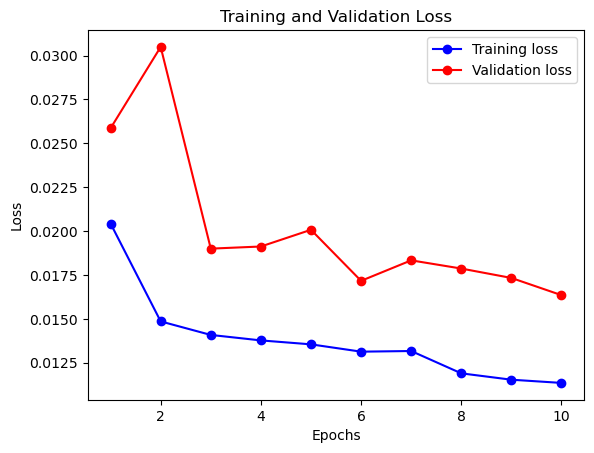

In [6]:
# plot the training curve
def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(train_losses, val_losses)

In [7]:
# evaluate the model
def evaluate_model(feature_extractor, model, test_loader):
    model.eval()
    test_loss = 0.0
    val_labels = []
    val_predictions = []
    with torch.no_grad():
        for images, labels, weight in test_loader:
            images, labels = torch.stack(images), torch.stack(labels)
            features = feature_extractor(images).view(images.size(0), -1)
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item() * images.size(0)
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(outputs.squeeze().cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    mae = mean_absolute_error(val_labels, val_predictions)
    r2 = r2_score(val_labels, val_predictions)
    print(f'Test Loss: {test_loss}')
    print(f'Validation MAE: {mae}')
    print(f'Validation R²: {r2}')
    
    return test_loss, mae, r2

evaluate_model(feature_extractor, model, val_loader)

Test Loss: 1.7828966417540395
Validation MAE: 1.0516518354415894
Validation R²: 0.30670990658529285


(1.7828966417540395, 1.0516518, 0.30670990658529285)

In [8]:
# save the model
torch.save(model.state_dict(), '/home/ubuntu/landscape-aesthetics/models/resnet50_weights.pth')
print("Model saved to tresnet50_weights.pth")

Model saved to tresnet50_weights.pth
